## 0. 라이브러리 / 기본셋업

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [3]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
# 혹시 코랩환경을 사용하신다면 왼쪽 폴더모양 아이콘을 눌러 "train_data.csv"를 드래그&드롭으로 업로드한 후 사용해주세요
DATA_PATH = '/opt/ml/input/data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])

df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 7.79 s, sys: 628 ms, total: 8.42 s
Wall time: 8.42 s


## 1.1 기본적인 내용 파악

정리하면,   
+ `userID` 사용자의 고유 번호입니다. 총 7,442명의 학생이 있습니다.   
+ `assessmentItemID` 사용자가 푼 문항의 일련 번호입니다.   
+ `testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
+ `answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
+ `Timestamp` 사용자가 문항을 푼 시간 정보입니다.   
+ `KnowledgeTag` 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.   
특성 별로 자세히 살펴봅시다.

### 특성의 기본 정보

In [3]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [4]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


In [5]:
df.nunique()

userID                 6698
assessmentItemID       9454
testId                 1537
answerCode                2
Timestamp           2076774
KnowledgeTag            912
dtype: int64

In [6]:
df.groupby('userID').assessmentItemID.nunique()

userID
0       745
1       879
2       276
5       833
6       887
       ... 
7436     15
7437     16
7438     16
7440     15
7441      9
Name: assessmentItemID, Length: 6698, dtype: int64

In [7]:
df.groupby('testId').assessmentItemID.nunique()

testId
A010000001    5
A010000002    5
A010000003    5
A010000004    5
A010000005    5
             ..
A090000070    8
A090000071    8
A090000072    6
A090000073    6
A090000074    6
Name: assessmentItemID, Length: 1537, dtype: int64

### 일련 번호 분석

#### 첫 번째 단어 A
A 밖에 없는 것을 확인할 수 있음

In [8]:
df['assessmentItemID'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

#### 문항 일련 번호 내 시험지 번호
문항 일련 번호의 1-6번째 자리와 시험지 번호의 1-3번째+마지막3자리 합이 같은지 확인합니다.   
전체 데이터 개수와 일치함을 알 수 있습니다.

In [9]:
sum(df['assessmentItemID'].apply(
    lambda x: x[1:7]) == df['testId'].apply(lambda x: x[1:4]+x[7:])
)

2266586

#### 시험지 번호 가운데 3자리 모두 000

In [10]:
df['testId'].apply(lambda x: x[4:7]).unique()

array(['000'], dtype=object)

## 1.2 기술 통계량 분석

In [4]:
def percentile(s):
    return np.sum(s) / len(s)

### 사용자 분석
`groupby` 함수는 정형 데이터의 집계/요약을 하는 데 있어 굉장히 중요한 분석 도구입니다. 가장 기본적인 사용문법은 -
+ `(데이터프레임).groupby(분리할KEY).agg({합치고싶은특성: 어떻게합칠지, ...})`
로 사용하면 됩니다! 라고 하기엔 이렇게만 보면 `groupby`는 이해가 어렵습니다.


가령 사용자별로 몇 개의 문제를 풀었는지 보고싶다고 하면,    
`df.groupby("userID").agg({"assessmentItemID": "count"})`   
라고 사용하면, `userID`의 개개인 고유값에 대해 `assessmentItemID`값을 모두 가져와서 몇 개 있는지 세주고 싶으면 `count` 해줍니다. 일반적으로 이렇게 문자열을 넣어주면 `pandas` 라이브러리 내에 미리 만들어진 집계함수를 사용할 수 있습니다. 자세한 사용법은 공식 Documentation을 참고.

In [12]:
missing = []
for i in range(7442):
    if len(df[df.userID == i]) == 0:
        missing.append(i)

In [13]:
len(missing)

744

In [14]:
df[df.userID == 0]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
740,0,A080129002,A080000129,1,2020-12-23 03:35:54,2723
741,0,A080129003,A080000129,0,2020-12-23 03:37:20,2725
742,0,A080129004,A080000129,1,2020-12-23 03:38:43,2725
743,0,A080129005,A080000129,0,2020-12-23 03:40:14,2725


In [15]:
stu_grouped = df.groupby('userID')
# stu_grouped.get_group(0) # same as upper code
stu_grouped.get_group(0).describe()

,userID,answerCode,KnowledgeTag
count,745.0,745.000000,745.000000
mean,0.0,0.630872,3704.297987
std,0.0,0.482893,3319.936352
min,0.0,0.000000,23.000000
25%,0.0,0.000000,627.000000
50%,0.0,1.000000,2725.000000
75%,0.0,1.000000,7034.000000
max,0.0,1.000000,10606.000000


* around 700 users repeated some items

In [16]:
unique_count = 0 # max 6698
repeated_user = []
for k, group in stu_grouped:
    if group.assessmentItemID.nunique() == len(group):
        unique_count += 1
    else:
        repeated_user.append(k)
print(unique_count)
print(repeated_user)

5999
[1, 6, 16, 34, 40, 54, 65, 67, 68, 69, 72, 80, 83, 86, 98, 99, 104, 112, 115, 116, 117, 121, 122, 127, 133, 135, 143, 144, 155, 157, 158, 160, 165, 166, 174, 176, 183, 186, 195, 208, 218, 221, 230, 248, 251, 261, 263, 265, 271, 275, 276, 287, 290, 294, 307, 314, 316, 319, 320, 327, 330, 332, 333, 344, 348, 353, 354, 360, 365, 379, 383, 393, 394, 397, 399, 405, 408, 409, 411, 413, 419, 424, 429, 457, 461, 469, 470, 473, 483, 485, 487, 498, 500, 502, 504, 509, 513, 517, 523, 526, 529, 530, 531, 534, 535, 537, 547, 554, 555, 562, 588, 589, 597, 599, 602, 607, 608, 609, 612, 619, 623, 631, 637, 644, 658, 661, 665, 675, 693, 706, 711, 720, 721, 724, 726, 728, 733, 743, 746, 749, 753, 769, 777, 778, 779, 780, 782, 787, 788, 790, 796, 810, 811, 823, 828, 840, 850, 854, 858, 862, 868, 875, 897, 909, 910, 911, 914, 921, 924, 927, 930, 934, 936, 943, 950, 959, 960, 961, 965, 968, 990, 1004, 1005, 1017, 1019, 1023, 1031, 1035, 1038, 1041, 1043, 1048, 1049, 1055, 1057, 1062, 1063, 1067, 1069,

In [17]:
item_1 = stu_grouped.get_group(1).assessmentItemID.to_numpy()
i_idx, i_cnt = np.unique(item_1, return_counts=True)
i_idx[i_cnt>1]

array(['A040155001', 'A040155002', 'A040155003', 'A040155004',
       'A040155005', 'A040155006', 'A040156001', 'A040156002',
       'A040156003', 'A040156004', 'A040156005', 'A040156006',
       'A040157001', 'A040157002', 'A040157003', 'A040157004',
       'A040157005', 'A040157006', 'A040158001', 'A040158002',
       'A040158003', 'A040158004', 'A040158005', 'A040158006',
       'A040160001', 'A040160002', 'A040160003', 'A040160004',
       'A040160005', 'A040161001', 'A040161002', 'A040161003',
       'A040161004', 'A040161005', 'A040161006', 'A040161007',
       'A040162001', 'A040162002', 'A040162003', 'A040162004',
       'A040163001', 'A040163002', 'A040163003', 'A040163004',
       'A040163005', 'A040164001', 'A040164002', 'A040164003',
       'A040164004', 'A040164005', 'A040165001', 'A040165002',
       'A040165003', 'A040165004'], dtype=object)

In [18]:
item_5112 = stu_grouped.get_group(5112).assessmentItemID.to_numpy()
i_idx, i_cnt = np.unique(item_5112, return_counts=True)
i_idx[i_cnt>1]

array(['A040173001', 'A040173002', 'A040173003', 'A040173004',
       'A040173005'], dtype=object)

In [19]:
stu_1 = stu_grouped.get_group(1)

In [20]:
stu_1[stu_1['assessmentItemID'] == 'A040160005']

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
1239,1,A040160005,A040000160,0,2020-07-07 23:04:21,11236
1443,1,A040160005,A040000160,1,2020-08-21 12:43:35,11236


In [21]:
stu_grouped.mean()

,answerCode,KnowledgeTag
userID,,
0,0.630872,3704.297987
1,0.853162,3968.296892
2,0.612319,2652.528986
5,0.795918,4964.165666
6,0.442997,2575.799131
...,...,...
7436,0.466667,807.666667
7437,0.375000,4053.375000
7438,0.750000,1994.562500


In [22]:
stu_grouped.get_group(0).answerCode.mean()

0.6308724832214765

### Time info

In [13]:
def get_hour(timestamp):
    timestamp = str(timestamp)
    return timestamp[-8:-6]

In [15]:
df['hour'] = df.Timestamp.apply(get_hour)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,hour
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,00
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,00
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,00
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,00
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,00


In [20]:
hour_groupby = df.groupby('hour').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
hour_groupby

,assessmentItemID,answerCode
hour,,
00,101137,0.649446
01,136702,0.644321
02,156892,0.642410
03,141911,0.632685
04,148677,0.633292
05,163289,0.624776
06,167792,0.629941
07,166396,0.643050
08,157963,0.667948


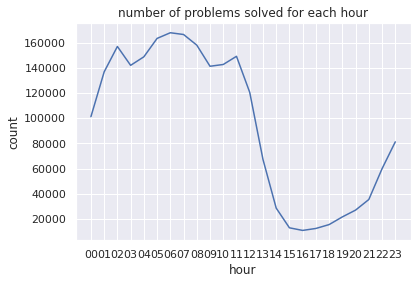

In [22]:
plt.plot(hour_groupby.assessmentItemID)
plt.title('number of problems solved for each hour')
plt.xlabel('hour')
plt.ylabel('count')
plt.show()

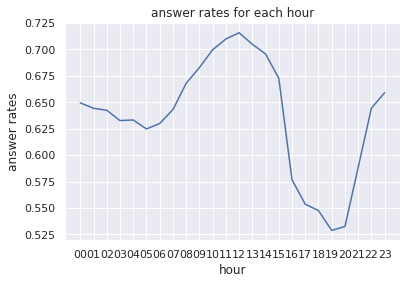

In [23]:
plt.plot(hour_groupby.answerCode)
plt.title('answer rates for each hour')
plt.xlabel('hour')
plt.ylabel('answer rates')
plt.show()

### Item info

In [23]:
df.assessmentItemID.unique()

array(['A060001001', 'A060001002', 'A060001003', ..., 'A010180004',
       'A010180005', 'A010180006'], dtype=object)

In [24]:
df.assessmentItemID.nunique()

9454

In [25]:
item = df.assessmentItemID.values
f = lambda x: x[-3:]
items = np.array([int(f(i)) for i in item])

In [26]:
print(f"""mean: {items.mean()}
std: {items.std()}
median: {np.median(items)}
max: {np.max(items)}
""")

mean: 3.7119716613444185
std: 2.034433816777386
median: 4.0
max: 13



In [27]:
t_f = lambda x: x[1:]
t_items = np.array([int(t_f(i)) for i in item])
_, t_count = np.unique(t_items, return_counts = True)

In [28]:
print(f"""total items: {item}
length of total: {len(item)}
length of unique: {len(t_count)}
total count: {t_count}
mean: {np.mean(t_count)}
std: {np.std(t_count)}
min: {np.min(t_count)}
median: {np.median(t_count)}
max: {np.max(t_count)}
BRACKCHEE: {np.where(t_count == 0)[0]}
CHECK!: {np.sum(t_count)} 
""")

total items: ['A060001001' 'A060001002' 'A060001003' ... 'A040165002' 'A040165003'
 'A040165004']
length of total: 2266586
length of unique: 9454
total count: [317 317 317 ...  45  45  45]
mean: 239.74888935900148
std: 71.8899888397659
min: 43
median: 230.0
max: 454
BRACKCHEE: []
CHECK!: 2266586 



/tmp/ipykernel_11735/1649580541.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


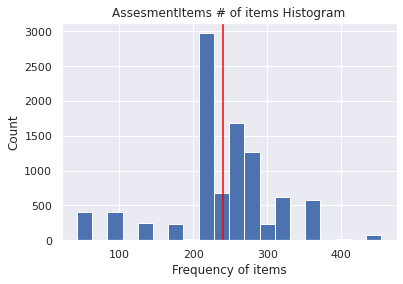

In [29]:
fig, ax = plt.subplots()

ax.hist(t_count, bins=20)

ax.set_title('AssesmentItems # of items Histogram')
ax.set_xlabel('Frequency of items')
ax.set_ylabel('Count')
ax.axvline(t_count.mean(), color='red')
ax.grid(b=True)

### KT info  
  
* pdf: min 50, max 14350  
  * if pdf version assumes full data, it would contain min 44.0  
  * AHA! some items from each `KnowledgeTag` have been dropped out!? (6~1458?)

In [30]:
kt_groupby = df.groupby('KnowledgeTag').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
kt_groupby.describe()

,assessmentItemID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


In [94]:
uk_groupby = df.groupby(['userID','KnowledgeTag']).agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
uk_groupby.describe()

,assessmentItemID,answerCode
count,440802.000000,440802.000000
mean,5.141959,0.630016
std,3.802096,0.358648
min,1.000000,0.000000
25%,2.000000,0.333333
50%,5.000000,0.727273
75%,6.000000,1.000000
max,108.000000,1.000000


/tmp/ipykernel_11735/797228561.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


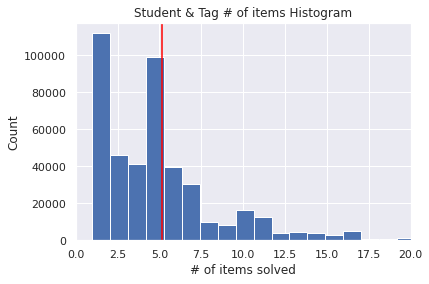

In [104]:
fig, ax = plt.subplots()

uk_groupby['assessmentItemID'].hist(bins=100, ax=ax)

ax.set_title('Student & Tag # of items Histogram')
ax.set_xlim(0,20)
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(uk_groupby['assessmentItemID'].mean(), color='red')
ax.grid(b=True)

/tmp/ipykernel_11735/2290942324.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


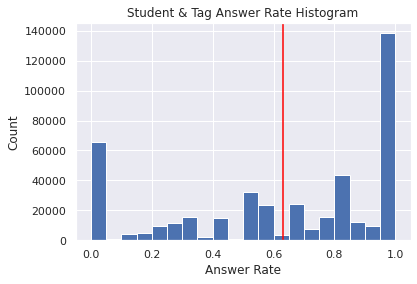

In [109]:
fig, ax = plt.subplots()

uk_groupby['answerCode'].hist(bins=20)

ax.set_title('Student & Tag Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(uk_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

### Test info

* pdf: min 200, max 4400  
  * if pdf version assumes full data, it would contain min 172.0  
  * AHA! some items from each `testId` have been dropped out!? (27~440?)

In [31]:
test_groupby = df.groupby('testId').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,assessmentItemID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


In [5]:
ut_groupby = df.groupby(['userID','testId']).agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
ut_groupby.describe()

,assessmentItemID,answerCode
count,365164.000000,365164.000000
mean,6.207036,0.668726
std,1.712452,0.307952
min,2.000000,0.000000
25%,5.000000,0.428571
50%,6.000000,0.800000
75%,7.000000,1.000000
max,27.000000,1.000000


In [8]:
np.sum(ut_groupby.values[:,0])

2266586.0

In [10]:
np.sum(ut_groupby['assessmentItemID'][ut_groupby['answerCode'] == 1.0].values)

556660

In [93]:
# np.where(ut_groupby['answerCode'].values == 1, 1, 0)
ut_groupby.answerCode

userID  testId    
0       A020000172    0.666667
        A020000174    0.800000
        A020000181    0.500000
        A020000182    1.000000
        A020000183    1.000000
                        ...   
7440    A030000136    0.600000
        A030000197    0.200000
        A050000096    0.400000
7441    A030000071    0.200000
        A040000165    1.000000
Name: answerCode, Length: 365164, dtype: float64

/tmp/ipykernel_11735/3743129742.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


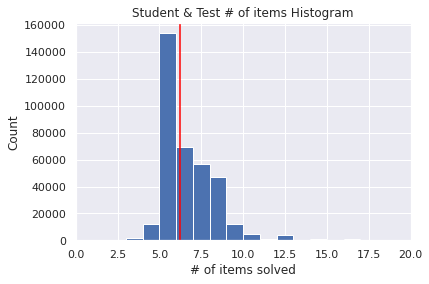

In [108]:
fig, ax = plt.subplots()

ut_groupby['assessmentItemID'].hist(bins=25, ax=ax)

ax.set_title('Student & Test # of items Histogram')
ax.set_xlim(0,20)
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(ut_groupby['assessmentItemID'].mean(), color='red')
ax.grid(b=True)

/tmp/ipykernel_11735/1483362940.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


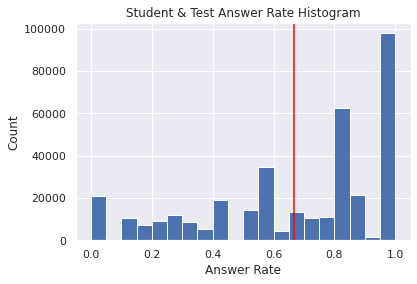

In [67]:
fig, ax = plt.subplots()

ut_groupby['answerCode'].hist(bins=20)

ax.set_title('Student & Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(ut_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

In [4]:
from mpl_toolkits.mplot3d import Axes3D

In [9]:
ut_groupby = ut_groupby.unstack().fillna(0).stack()

In [10]:
xlabels = ut_groupby.index.get_level_values('userID').unique()
ylabels = ut_groupby.index.get_level_values('testId').unique()
x = np.arange(xlabels.shape[0])
y = np.arange(ylabels.shape[0])

In [11]:
x_M, y_M = np.meshgrid(x, y, copy=False)

In [20]:
print(x_M)
print(y_M)

[[   0    1    2 ... 6695 6696 6697]
 [   0    1    2 ... 6695 6696 6697]
 [   0    1    2 ... 6695 6696 6697]
 ...
 [   0    1    2 ... 6695 6696 6697]
 [   0    1    2 ... 6695 6696 6697]
 [   0    1    2 ... 6695 6696 6697]]
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1534 1534 1534 ... 1534 1534 1534]
 [1535 1535 1535 ... 1535 1535 1535]
 [1536 1536 1536 ... 1536 1536 1536]]


In [12]:
L = []
for i, group in ut_groupby.groupby(level=1)['answerCode']:
    L.append(group.values)
z = np.hstack(L).ravel()

In [13]:
z.size

10294826

In [21]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Making the intervals in the axes match with their respective entries
ax.w_xaxis.set_ticks(x + 0.5/2.)
ax.w_yaxis.set_ticks(y + 0.5/2.)

# # Renaming the ticks as they were before
# ax.w_xaxis.set_ticklabels(xlabels)
# ax.w_yaxis.set_ticklabels(ylabels)

# Labeling the 3 dimensions
ax.set_xlabel('userID')
ax.set_ylabel('testId')
ax.set_zlabel('answerCode')

# # Choosing the range of values to be extended in the set colormap
# values = np.linspace(0.01, 102948.26, x_M.ravel().shape[0])

# # Selecting an appropriate colormap
# colors = plt.cm.Spectral(values)
ax.bar3d(x_M.ravel(), y_M.ravel(), z*0, dx=0.5, dy=0.5, dz=z) # , color=colors)
plt.show()

### User info

Combine with `test_data` works quite fine (wrt. min, max)

In [32]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


In [33]:
stu_groupby

,assessmentItemID,answerCode
userID,,
0,745,0.630872
1,933,0.853162
2,276,0.612319
5,833,0.795918
6,921,0.442997
...,...,...
7436,15,0.466667
7437,16,0.375000
7438,16,0.750000


#### 사용자 문항 개수 도수분포표

<AxesSubplot:>

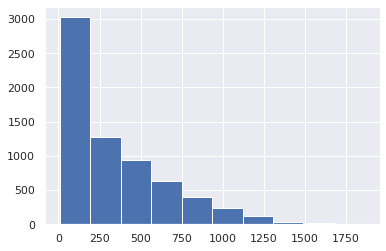

In [34]:
stu_groupby['assessmentItemID'].hist()

/tmp/ipykernel_11735/417151868.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


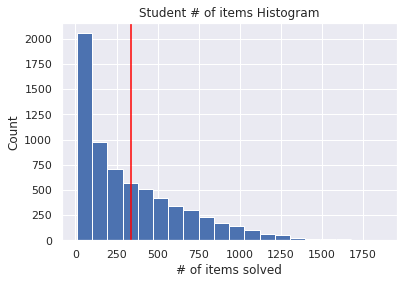

In [35]:
fig, ax = plt.subplots()

stu_groupby['assessmentItemID'].hist(bins=20, ax=ax)

ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='red')
ax.grid(b=True)

#### 사용자 정답률 도수분포표

/tmp/ipykernel_11735/1795024208.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


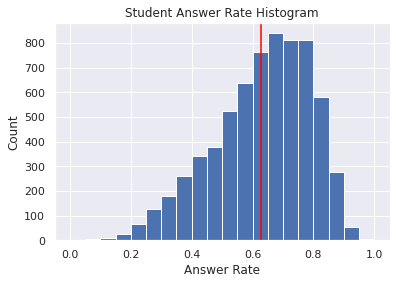

In [36]:
fig, ax = plt.subplots()

stu_groupby['answerCode'].hist(bins=20)

ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

### 문항 별 정답률 분석

* 10% of users have been dropped out!

In [37]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
prob_groupby.describe()

,userID,answerCode
count,9454.000000,9454.000000
mean,239.748889,0.654256
std,71.893791,0.195488
min,43.000000,0.049430
25%,220.000000,0.505548
50%,230.000000,0.666667
75%,271.000000,0.820513
max,454.000000,0.996310


/tmp/ipykernel_11735/833152311.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


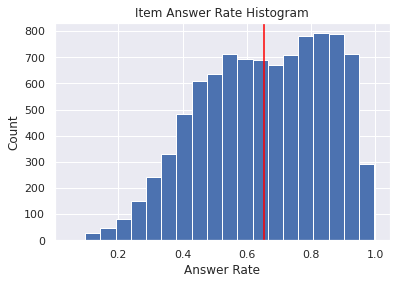

In [38]:
fig, ax = plt.subplots()
prob_groupby['answerCode'].hist(bins=20)
ax.set_title('Item Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(prob_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

### 시험지 별 정답률 분석

In [39]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


/tmp/ipykernel_11735/4199184374.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


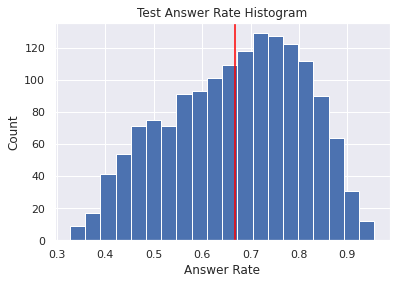

In [40]:
fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

### 태그 별 정답률 분석

In [5]:
kt_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
kt_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


/tmp/ipykernel_12676/1311342409.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


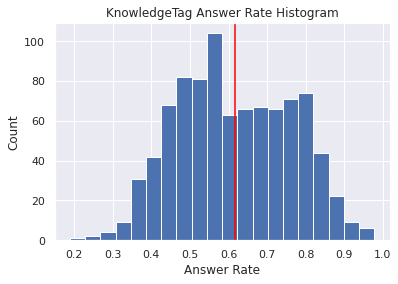

In [6]:
fig, ax = plt.subplots()
kt_groupby['answerCode'].hist(bins=20)
ax.set_title('KnowledgeTag Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(kt_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

## 1.3 일반적인 EDA

### 문항을 더 많이 푼 학생이 문제를 더 맞추는가?
분포도 위에 전반적인 동향을 살피고 싶을 때 `seaborn` 라이브러리의 `lmplot`을 사용하면 좋습니다.

Text(0.5, 1.0, '# of Questions - Answer Rate')

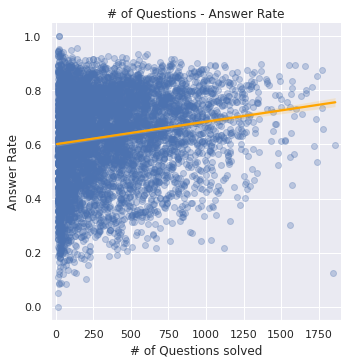

In [41]:
g = sns.lmplot(
    data=stu_groupby,
    x='assessmentItemID',
    y='answerCode',
    scatter_kws={'alpha':0.3},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

In [42]:
# 상관관계는 특성 간 인과를 알려주지 않지만 어느 정도 살펴보기는 해야하는 지표입니다.
print(f"정답률과 문제를 푼 개수 사이 상관관계: {stu_groupby.corr()['assessmentItemID']['answerCode']:.3f}")

정답률과 문제를 푼 개수 사이 상관관계: 0.168


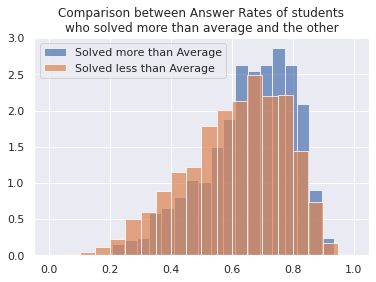

In [43]:
fig, ax = plt.subplots()

ax.set_title('Comparison between Answer Rates of students\nwho solved more than average and the other')
stu_num_mean = stu_groupby['assessmentItemID'].mean()
stu_groupby[stu_groupby['assessmentItemID'] >= stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved more than Average'
)
stu_groupby[stu_groupby['assessmentItemID'] < stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved less than Average'
)
ax.legend()

### 더 많이 노출된 태그가 정답률이 더 높은가?

In [44]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


Text(0.5, 1.0, '# of Tags Exposed - Answer Rate')

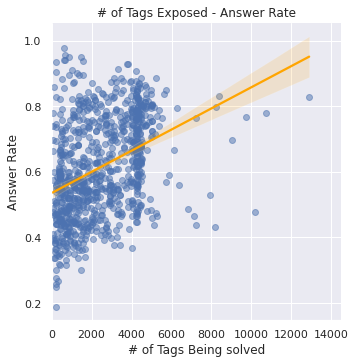

In [45]:
g = sns.lmplot(
    data=tag_groupby,
    x='userID',
    y='answerCode',
    scatter_kws={'alpha':0.5},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Tags Being solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 14500))

ax = plt.gca()
ax.set_title('# of Tags Exposed - Answer Rate')

In [46]:
tag_groupby

,userID,answerCode
KnowledgeTag,,
23,1800,0.584444
24,358,0.614525
25,92,0.858696
26,2432,0.614309
30,539,0.536178
...,...,...
11253,4282,0.739374
11265,454,0.676211
11269,2417,0.557716


In [47]:
print(f"태그를 풀었던 사용자의 수와 정답률 사이 상관관계: {tag_groupby.corr()['answerCode']['userID']:.3f}")

태그를 풀었던 사용자의 수와 정답률 사이 상관관계: 0.376


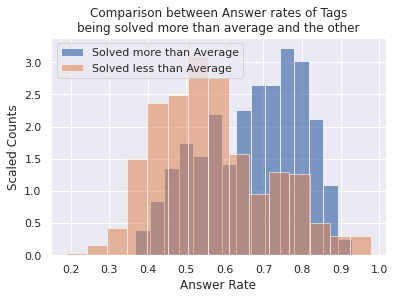

In [48]:
fig, ax = plt.subplots()

tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')

tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average'
)
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average'
)
ax.legend()

### 문항을 풀수록 실력이 늘어나는가?

In [49]:
# 누적합
_cumsum = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
cum_ans['userID'] = df['userID']
window_sizes = [30, 70, 100, 120]

푼 문항의 갯수가 중앙값 부근인 10명의 학생들

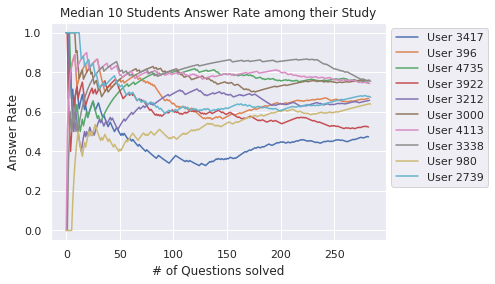

In [50]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Students Answer Rate among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'assessmentItemID': 'count'}).sort_values(by='assessmentItemID').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

정답률이 중앙값 부근인 10명의 학생들

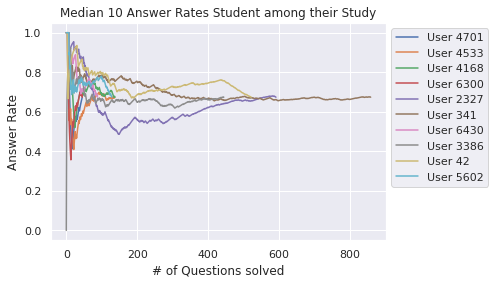

In [51]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Answer Rates Student among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'answerCode': percentile}).sort_values(by='answerCode').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

Window_size 적용

In [52]:
def plot_rolled_answerrate(userID, ax, window_sizes=[70, 100, 120]):
    
    ax.set_title(f'Students Answer Rate among their Study - User {userID}')
    ax.set_xlabel('# of Questions solved')
    ax.set_ylabel('Answer Rate')

    cum_ans[cum_ans['userID'] == userID]['answerCode'].reset_index(drop=True).plot(
        ax=ax, label=f'Without Window', linewidth=3)

    for wdw_sz in window_sizes:    
        (df[df.userID == userID]['answerCode'].rolling(wdw_sz).sum().reset_index(drop=True) / wdw_sz).plot(
            ax=ax, label=f'Window size {wdw_sz}', alpha=0.8)

    ax.legend()

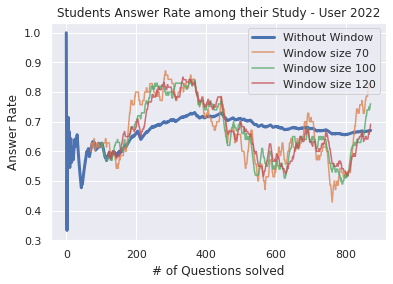

In [53]:
fig, ax = plt.subplots()
plot_rolled_answerrate(2022, ax)

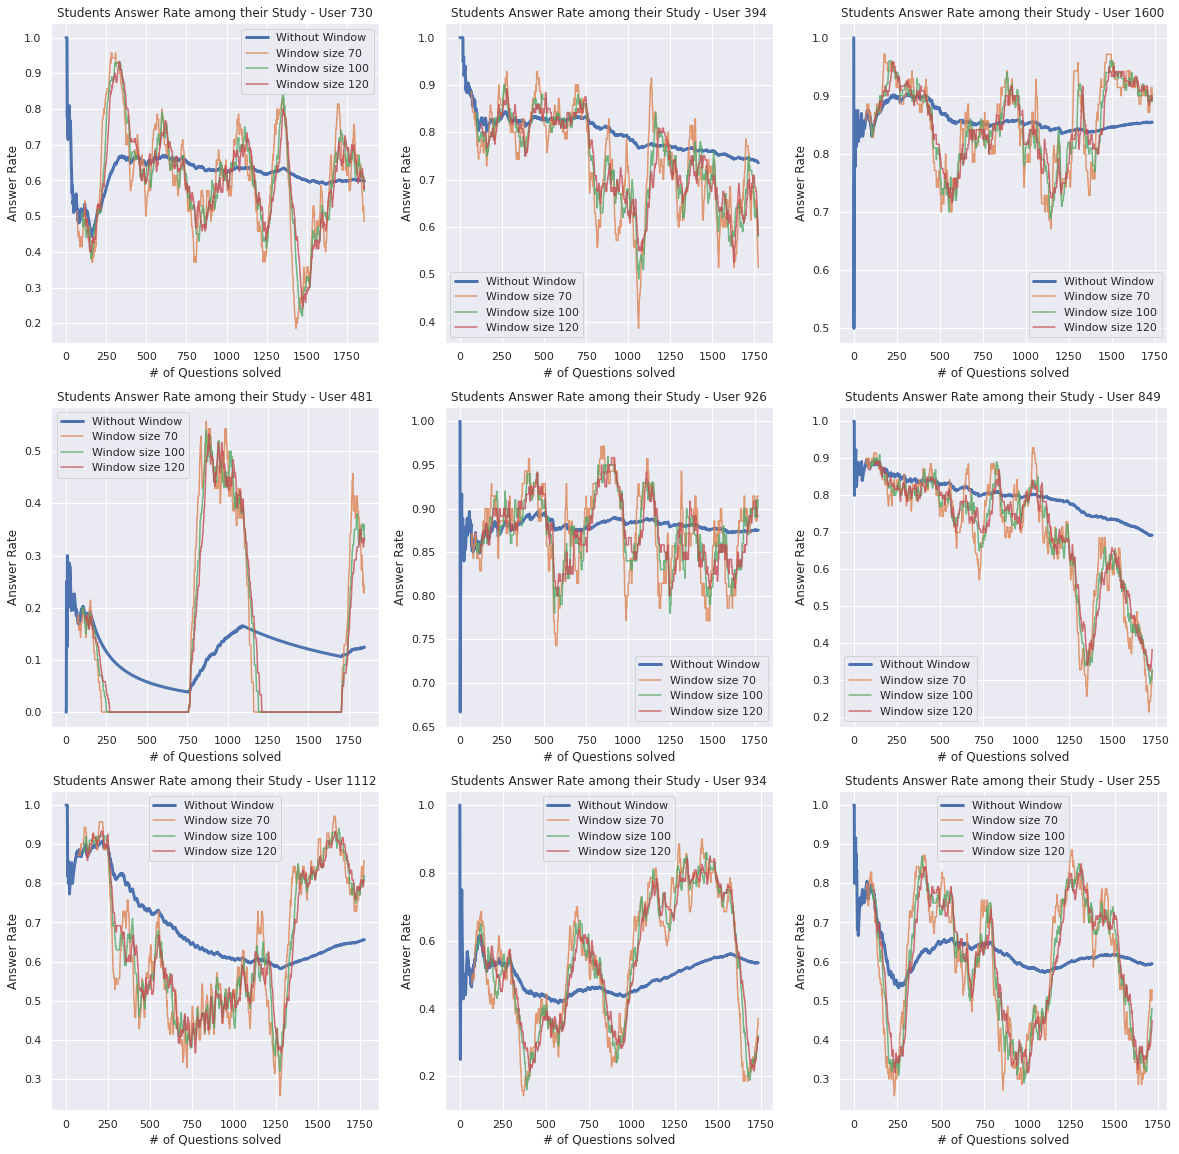

In [54]:
idx = df.groupby('userID').agg({'answerCode': 'count'}).sort_values(by='answerCode', ascending=False).iloc[:9].index
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
plt.title('Top 9 Students who solved the most problems')
for i, userID in enumerate(idx):
    
    r, c = i%3, i//3
    plot_rolled_answerrate(userID, axes[r, c])

### 문항을 푸는 데 걸린 시간과 정답률 사이의 관계는?

In [55]:
df.Timestamp.values

array(['2020-03-24T00:17:11.000000000', '2020-03-24T00:17:14.000000000',
       '2020-03-24T00:17:22.000000000', ...,
       '2020-08-21T01:06:50.000000000', '2020-08-21T01:07:36.000000000',
       '2020-08-21T01:08:49.000000000'], dtype='datetime64[ns]')

In [56]:
str(df.Timestamp[0])[-8:-6]

'00'

In [57]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff

elapsed_answer = df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

In [58]:
elapsed_answer['userID'] > 100

elapsed
0.0            True
1.0            True
2.0            True
3.0            True
4.0            True
              ...  
24730516.0    False
24870940.0    False
24916659.0    False
24928478.0    False
25602295.0    False
Name: userID, Length: 223234, dtype: bool

(-10.0, 650.0)

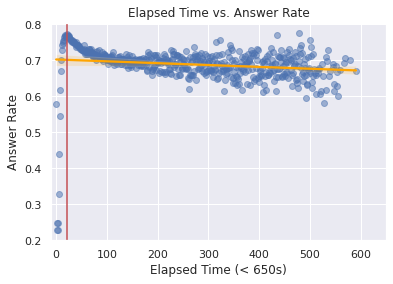

In [59]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_hist.index[:-1], y=elapsed_hist.answerCode.values[:-1],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')
ax.set_xlim(-10, 650)

# 2. Daily Mission

### (a)
사실 위에서 그린 문항수-정답률 그래프는 큰 insight를 주지 못하는 것 같습니다. 같은 문항을 푼 학생들의 정답률은 당연히 상이하겠지만, 이 평균을 보는 것이 더 의미가 있을 것 같은데 아래처럼 보면 너무 점이 많아서 insight를 얻기 힘드네요.
![image.png](attachment:image.png)

그러면 이번엔 같은 문항수를 푼 학생들이 있다면, 그 학생들의 평균을 찍어서 그래프를 그려봅시다. 가령 9문항을 푼 학생이 10명이라면, 그 학생들의 평균이 찍히도록 말이죠! 아래와 같은 형태이면 좋을 것 같습니다.
- **x-axis**: 사용자가 푼 문항의 수
- **y-axis**: 정답률   
<br>
![image.png](mission_a.png)

### (b)

그런데 위 그래프도... 사실 점이 너무 많습니다. 이것보다 더 줄이려면 단순히 같은 문항수를 푼 학생들끼리 평균을 집계하는 것이 아니라, 어느 정도 비슷한 문항을 푼 학생들을 전부 집계하면 좋을 것 같네요. 예를 들면 9 ~ 14문항을 푼 학생들을 묶어서 평균을 내는 것처럼요.   
`bins` 값을 주었을 때 bins 만큼 그래프에 점이 찍히도록, 예를 들어 bins=500이었다면 아래와 같이 500개의 bin을 만들어서 그래프가 그려지도록 해주세요 :)    

![image.png](mission_b.png)

In [60]:
# stu_groupby[stu_groupby.assessmentItemID == 100]

stu_avg = stu_groupby.groupby('assessmentItemID').agg({
    # 'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_avg = stu_avg.reset_index()

Text(0.5, 1.0, '# of Questions - Answer Rate')

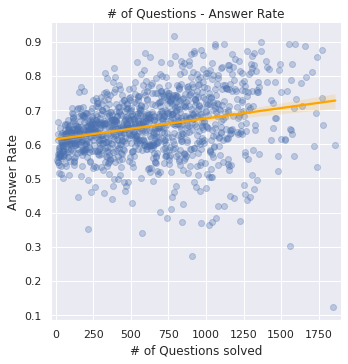

In [61]:
g = sns.lmplot(
    data=stu_avg,
    x='assessmentItemID',
    y='answerCode',
    scatter_kws={'alpha':0.3},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')